In [55]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_score 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone
from sklearn import linear_model
import statsmodels.api as sm
#silence future warning message
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
item = pd.read_csv('items.csv')

In [3]:
df = pd.read_csv('sales_train.csv')

In [4]:
df = df.merge(item, left_on=df['item_id'], right_on = item['item_id'])

In [5]:
df.head()

,key_0,date,date_block_num,shop_id,item_id_x,item_price,item_cnt_day,item_name,item_id_y,item_category_id
0,22154,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
1,22154,23.01.2013,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
2,22154,20.01.2013,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
3,22154,02.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
4,22154,03.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37


In [6]:
df.drop(['item_name','item_id_y'], axis =1, inplace = True)
df = df.rename(columns={'item_id_x': 'item_id'})

In [7]:
df = df.drop(['date'], axis = 1)

In [8]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

rows_with_NaN.head(50)

,key_0,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id


In [9]:
def overview(dataframe):
    
    data_resumen = {'Valores Unicos':dataframe.nunique(),'No-Nulos': dataframe.notnull().sum(), 'Nulos': dataframe.isnull().sum(), 'Formato': dataframe.dtypes, 'Min': dataframe.min(), 'Max': dataframe.max()}
    resumen = pd.DataFrame(data=data_resumen)
    return resumen

In [10]:
overview(df)

,Valores Unicos,No-Nulos,Nulos,Formato,Min,Max
key_0,21807,2935849,0,int64,0.0,22169.0
date_block_num,34,2935849,0,int64,0.0,33.0
shop_id,60,2935849,0,int64,0.0,59.0
item_id,21807,2935849,0,int64,0.0,22169.0
item_price,19993,2935849,0,float64,-1.0,307980.0
item_cnt_day,198,2935849,0,float64,-22.0,2169.0
item_category_id,84,2935849,0,int64,0.0,83.0


In [11]:
#Get rid of outliers
df = df[(df['item_price']<100000) & (df['item_price']>=0)]
df = df[(df['item_cnt_day']<1000) & (df['item_cnt_day']>=0)]

# plot after outliers removal
#plot_features = ['item_price','item_cnt_day']
#for f in plot_features:
#   df.boxplot(f,f)


In [12]:
df2 = df.groupby(by = ['date_block_num','shop_id','item_category_id','item_id','item_price'])['item_cnt_day'].sum()

In [13]:
df2 = df2.reset_index(drop=False)
df2['total_sales'] = df2['item_price'] * df2['item_cnt_day']
df2.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day,total_sales
0,0,0,2,5572,1322.0,10.0,13220.0
1,0,0,2,5573,560.0,1.0,560.0
2,0,0,2,5575,806.0,4.0,3224.0
3,0,0,2,5576,2231.0,5.0,11155.0
4,0,0,2,5609,2381.0,1.0,2381.0


In [14]:
df2['item_id_avg_item_price'] = df2.groupby(['date_block_num','shop_id','item_id'])['total_sales'].transform('mean')


In [15]:
df3 = df2.groupby(by = ['date_block_num','shop_id','item_id'])['item_id_avg_item_price'].mean()

In [16]:
df3 = df3.reset_index(drop=False)
df3.head(6)

,date_block_num,shop_id,item_id,item_id_avg_item_price
0,0,0,32,1326.0
1,0,0,33,1041.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5
5,0,0,61,195.0


In [17]:
df3['item_id_sum_item_cnt_day'] = df2.groupby(by = ['date_block_num','shop_id','item_id'])['item_cnt_day'].transform('sum')
df3['item_id_avg_item_cnt_day'] = df2.groupby(by = ['date_block_num','shop_id','item_id'])['item_cnt_day'].transform('mean')

In [18]:
df3.head()

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day
0,0,0,32,1326.0,10.0,10.0
1,0,0,33,1041.0,1.0,1.0
2,0,0,35,247.0,4.0,4.0
3,0,0,43,221.0,5.0,5.0
4,0,0,51,128.5,1.0,1.0


In [19]:
df3['shop_id_avg_item_price'] = df2.groupby(['date_block_num','shop_id'])['total_sales'].transform('mean')

df3['shop_id_avg_item_price'] = round(df3['shop_id_avg_item_price'],2)

In [20]:
df3['shop_id_sum_item_cnt_day'] = df2.groupby(['date_block_num','shop_id'])['item_cnt_day'].transform('sum')

In [21]:
df3.sample(20)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day
359282,6,15,2432,599.0,1.0,1.000000,1278.57,2870.0
1070976,20,10,16444,63.0,10.0,5.000000,1825.33,1804.0
502317,8,44,20200,249.0,4.0,2.000000,1473.60,1299.0
631899,11,15,14229,1089.0,1.0,1.000000,2784.48,6463.0
105165,1,41,2751,2499.0,12.0,4.000000,1811.35,11183.0
697866,12,17,11829,629.3,1.0,1.000000,2018.51,3572.0
1435870,28,38,19439,3998.5,1.0,1.000000,1736.25,1631.0
1513718,31,2,3688,13794.0,2.0,1.000000,2260.52,1572.0
662128,11,41,15646,248.0,1.0,1.000000,2436.82,1956.0
1259468,24,10,11645,95.0,1.0,1.000000,3407.37,9880.0


In [22]:
df3['shop_id_mean_item_cnt_day'] = df2.groupby(['date_block_num','shop_id'])['item_cnt_day'].transform('mean')
df3['shop_id_mean_item_cnt_day'] = round(df3['shop_id_mean_item_cnt_day'],2)
df3.head()

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day
0,0,0,32,1326.0,10.0,10.0,1228.84,5578.0,2.31
1,0,0,33,1041.0,1.0,1.0,1228.84,5578.0,2.31
2,0,0,35,247.0,4.0,4.0,1228.84,5578.0,2.31
3,0,0,43,221.0,5.0,5.0,1228.84,5578.0,2.31
4,0,0,51,128.5,1.0,1.0,1228.84,5578.0,2.31


In [23]:
df3['item_category_id_avg_item_price'] = df2.groupby(['date_block_num','shop_id','item_category_id'])['total_sales'].transform('mean')
df3['item_category_id_avg_item_price'] = round(df3['item_category_id_avg_item_price'],2)
df3.sample(20)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_avg_item_price
516587,8,58,3267,299.000,2.0,2.0,2557.37,3073.0,2.53,930.45
1362144,26,31,10578,299.000,11.0,11.0,2254.49,1340.0,1.65,10221.21
208055,3,27,12177,1179.000,1.0,1.0,362.16,1018.0,1.53,211.07
1056847,19,51,17977,237.000,3.0,3.0,1195.86,1605.0,1.62,397.70
881187,15,58,14491,98.000,1.0,1.0,1201.12,1789.0,1.74,411.00
1494808,30,28,11142,249.000,1.0,1.0,1602.12,1057.0,1.85,397.03
615395,10,56,786,359.000,1.0,1.0,2083.09,1016.0,2.05,238.65
240459,3,58,16921,149.000,2.0,2.0,1521.92,1886.0,1.87,1043.75
1437999,28,42,16626,299.000,1.0,1.0,1457.07,754.0,1.38,1484.09
592531,10,29,1167,1100.000,1.0,1.0,2833.27,2297.0,2.54,3787.50


In [24]:
df3['item_category_id_sum_item_cnt_day'] = df2.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].transform('sum')
df3['item_category_id_avg_item_cnt_day'] = df2.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].transform('mean')
df3['item_category_id_sum_item_cnt_day'] = round(df3['item_category_id_sum_item_cnt_day'],2)
df3['item_category_id_avg_item_cnt_day'] = round(df3['item_category_id_avg_item_cnt_day'],2)
df3.sample(20)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
163546,2,41,12836,149.0,3.0,1.5,1624.15,3164.0,2.09,717.87,40.0,1.43
671323,11,50,1809,1198.0,2.0,1.0,9606.25,2640.0,2.67,3213.08,95.0,1.76
728518,12,50,19687,3192.0,1.0,1.0,2060.47,3554.0,2.02,1486.05,59.0,2.95
1161849,22,24,8057,3000.0,1.0,1.0,3347.47,4030.0,2.75,381.50,247.0,1.29
957159,17,42,12321,149.0,1.0,1.0,1336.91,1832.0,1.71,397.30,265.0,1.35
1169811,22,30,5833,999.0,1.0,1.0,2300.08,1946.0,1.92,473.87,230.0,1.54
440757,7,31,20306,1198.0,1.0,1.0,1205.35,3709.0,1.92,520.81,287.0,1.39
61721,0,56,17351,149.0,1.0,1.0,1746.65,9412.0,2.64,880.59,3056.0,3.03
296483,5,4,16590,299.0,1.0,1.0,1306.18,3602.0,1.90,419.98,409.0,1.46
1108464,21,4,19893,399.0,2.0,1.0,1863.26,6217.0,2.31,1373.26,463.0,2.74


In [25]:
df_test = df3

In [26]:
df_test.count()

date_block_num                       1608224
shop_id                              1608224
item_id                              1608224
item_id_avg_item_price               1608224
item_id_sum_item_cnt_day             1608224
item_id_avg_item_cnt_day             1608224
shop_id_avg_item_price               1608224
shop_id_sum_item_cnt_day             1608224
shop_id_mean_item_cnt_day            1608224
item_category_id_avg_item_price      1608224
item_category_id_sum_item_cnt_day    1608224
item_category_id_avg_item_cnt_day    1608224
dtype: int64

In [27]:
df_test.head()

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,0,0,32,1326.0,10.0,10.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
1,0,0,33,1041.0,1.0,1.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
2,0,0,35,247.0,4.0,4.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
3,0,0,43,221.0,5.0,5.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
4,0,0,51,128.5,1.0,1.0,1228.84,5578.0,2.31,6211.25,53.0,3.31


In [28]:
for i in range(1,4):

    
    df_test[f'item_id_avg_item_price(t-{i})'] = df_test['item_id_avg_item_price'].shift(i)
    df_test[f'item_id_sum_item_cnt_day(t-{i})'] = df_test['item_id_sum_item_cnt_day'].shift(i)
    df_test[f'item_id_avg_item_cnt_day(t-{i})'] = df_test['item_id_avg_item_cnt_day'].shift(i)
    df_test[f'shop_id_avg_item_price(t-{i})'] = df_test['shop_id_avg_item_price'].shift(i)
    df_test[f'shop_id_sum_item_cnt_day(t-{i})'] = df_test['shop_id_sum_item_cnt_day'].shift(i)
    df_test[f'shop_id_mean_item_cnt_day(t-{i})'] = df_test['shop_id_mean_item_cnt_day'].shift(i)
    df_test[f'item_category_id_avg_item_price(t-{i})'] = df_test['item_category_id_avg_item_price'].shift(i)
    df_test[f'item_category_id_sum_item_cnt_day(t-{i})'] = df_test['item_category_id_sum_item_cnt_day'].shift(i)
    df_test[f'item_category_id_avg_item_cnt_day(t-{i})'] = df_test['item_category_id_avg_item_cnt_day'].shift(i)
    

In [29]:
df_test = df_test.fillna(0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608224 entries, 0 to 1608223
Data columns (total 39 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   date_block_num                          1608224 non-null  int64  
 1   shop_id                                 1608224 non-null  int64  
 2   item_id                                 1608224 non-null  int64  
 3   item_id_avg_item_price                  1608224 non-null  float64
 4   item_id_sum_item_cnt_day                1608224 non-null  float64
 5   item_id_avg_item_cnt_day                1608224 non-null  float64
 6   shop_id_avg_item_price                  1608224 non-null  float64
 7   shop_id_sum_item_cnt_day                1608224 non-null  float64
 8   shop_id_mean_item_cnt_day               1608224 non-null  float64
 9   item_category_id_avg_item_price         1608224 non-null  float64
 10  item_category_id_sum_item_cnt_

In [30]:
X, y = df_test.drop(['item_id_sum_item_cnt_day'], axis = 1) , df_test['item_id_sum_item_cnt_day']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=123)

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


class XyScaler(BaseEstimator, TransformerMixin):
    """Standardize a training set of data along with a vector of targets."""

    def __init__(self):
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        
    def fit(self, X, y, *args, **kwargs):
        """Fit the scaler to data and a target vector."""
        self.X_scaler.fit(X)
        self.y_scaler.fit(y.values.reshape(-1, 1))
        return self
    
    def transform(self, X, y, *args, **kwargs):
        """Transform a new set of data and target vector."""
        return (self.X_scaler.transform(X),
                self.y_scaler.transform(y.values.reshape(-1, 1)))

    def inverse_transform(self, X, y, *args, **kwargs):
        """Tranform from a scaled representation back to the original scale."""
        return (self.X_scaler.inverse_transform(X),
                self.y_scaler.inverse_transform(y.values.reshape(-1, 1)))

In [36]:
mdl2 = Lasso(alpha =0.01).fit(X_train, y_train)
y_pred = mdl2.predict(X_test)
mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

/Users/jiguzmans/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10771714.416326595, tolerance: 20725.56450865096
  model = cd_fast.enet_coordinate_descent(


(21.44149669835333, 0.8841099616526209)

In [37]:
def cv(X_train, y_train, base_estimator, n_folds, random_seed=154):
    """Estimate the in- and out-of-sample error of a model using cross
    validation.
    
    Parameters
    ----------
    
    X_train: np.array
      Matrix of predictors.
      
    y_train: np.array
      Target array.
      
    base_estimator: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.
      
    n_folds: int
      The number of folds in the cross validation.
      
    random_seed: int
      A seed for the random number generator, for repeatability.
    
    Returns
    -------
      
    train_cv_errors, test_cv_errors: tuple of arrays
      The training and testing errors for each fold of cross validation.
    """
    kf = KFold(n_splits=n_folds, random_state=random_seed)
    train_cv_errors, valid_cv_errors = np.empty(n_folds), np.empty(n_folds)

    for idx, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
        # Split into train and test
        X_cv_train, y_cv_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_cv_valid, y_cv_valid = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        # Standardize data, fit on training set, transform training and test.
        scaler = XyScaler()
        scaler.fit(X_cv_train, y_cv_train)
        X_cv_train_std, y_cv_train_std = scaler.transform(X_cv_train, y_cv_train)
        X_cv_valid_std, y_cv_valid_std = scaler.transform(X_cv_valid, y_cv_valid)

        # Fit ridge regression to training data.
        mdl = clone(base_estimator)
        mdl.fit(X_cv_train_std, y_cv_train_std)

        # Make predictions.
        y_cv_train_pred = mdl.predict(X_cv_train_std)
        y_cv_valid_pred = mdl.predict(X_cv_valid_std)

        # Calculate MSE.
        train_cv_errors[idx] = mean_squared_error(y_cv_train_std, y_cv_train_pred)
        valid_cv_errors[idx] = mean_squared_error(y_cv_valid_std, y_cv_valid_pred)
    return train_cv_errors, valid_cv_errors

In [38]:
train_cv_errors, valid_cv_errors = cv(X_train, y_train, base_estimator=Lasso(alpha=0.01), n_folds=5, random_seed=154)

In [39]:
print(f"Training CV error: {train_cv_errors.mean():.2f}")
print(f"Test CV error: {valid_cv_errors.mean():.2f}")

Training CV error: 0.11
Test CV error: 0.11


In [40]:
def train_at_various_alphas(X_train, y_train, model, alphas, n_folds, random_seed, **kwargs):
    """Train a regularized regression model using cross validation at various
    values of alpha.
    
    Parameters
    ----------
    
    X_train: np.array
      Matrix of predictors.
      
    y_train: np.array
      Target array.
      
    model: sklearn model class
      A class in sklearn that can be used to create a regularized regression
      object.  Options are `Ridge` and `Lasso`.
      
    alphas: numpy array
      An array of regularization parameters.
      
    n_folds: int
      Number of cross validation folds.
      
    Returns
    -------
    
    cv_errors_train, cv_errors_valid: tuple of DataFrame
      DataFrames containing the training and validating errors for each value of
      alpha and each cross validation fold.  Each row represents a CV fold, and
      each column a value of alpha.
    """
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_valid = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        train_cv_errors, valid_cv_errors = cv(X_train, y_train, base_estimator=model(alpha=alpha, **kwargs), n_folds=n_folds, random_seed=random_seed)
        cv_errors_train.loc[:,alpha] = train_cv_errors
        cv_errors_valid.loc[:,alpha] = valid_cv_errors
    return cv_errors_train, cv_errors_valid

In [42]:
alphas=np.logspace(-2,1, num=50)
cv_errors_train, cv_errors_valid = train_at_various_alphas(X_train, y_train, model=Lasso, alphas=alphas, n_folds=5, random_seed=154)

In [43]:
train_means, valid_means = cv_errors_train.mean(axis=0), cv_errors_valid.mean(axis=0)

In [44]:
alphas = valid_means.index
optimal_idx = np.argmin(valid_means.values)
optimal_alpha = alphas[optimal_idx]

In [45]:
#method 2:
optimal_alpha = valid_means.idxmin()
optimal_alpha

0.01

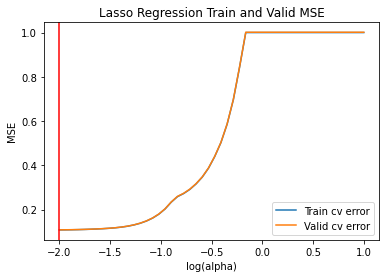

In [46]:
fig, ax = plt.subplots()
ax.plot(np.log10(alphas), train_means, label='Train cv error')
ax.plot(np.log10(alphas), valid_means, label='Valid cv error')
ax.axvline(np.log10(valid_means.idxmin()), color='red')
ax.legend()
ax.set_title('Lasso Regression Train and Valid MSE')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('MSE');

AttributeError: 'Series' object has no attribute 'info'

In [50]:
def model_selection(X_train, y_train, model, alphas=None):
    '''select Ridge/Lasso/LinearRegression model with optimal alpha
    Parameters:
    -----------
    model: either one in [Ridge, Lasso, LinearRegression]
    alphas (np.array or list): alpha values for Ridge or Lasso
    '''
    scaler = XyScaler()
    scaler.fit(X_train, y_train)
    X_train_std, y_train_std = scaler.transform(X_train, y_train)
    X_test_std, y_test_std = scaler.transform(X_test, y_test)
    if model is not LinearRegression:
        cv_errors_train, cv_errors_valid = train_at_various_alphas(X_train, y_train, model=model, alphas=alphas, n_folds=5, random_seed=154)
        train_means, valid_means = cv_errors_train.mean(axis=0), cv_errors_valid.mean(axis=0)
        optimal_alpha = valid_means.idxmin()
        mdl = model(alpha=optimal_alpha).fit(X_train_std, y_train_std)
    else: # model is LinearRegression:
        mdl = model().fit(X_train_std, y_train_std)
    y_pred_std = mdl.predict(X_test_std)
    mse = mean_squared_error(y_test_std, y_pred_std)
    return mse, model

In [51]:
mse_ridge, model_ridge = model_selection(X_train=X_train, y_train=y_train, model=Ridge, alphas=np.logspace(-2,4, num=50))
mse_lasso, model_lasso = model_selection(X_train=X_train, y_train=y_train, model=Lasso, alphas=np.logspace(-3,1, num=50))
mse_linear, model_linear = model_selection(X_train=X_train, y_train=y_train, model=LinearRegression)

In [52]:
print(f'Ridge rss={mse_ridge**.5:.3f}')
print(f'Lasso rss={mse_lasso**.5:.3f}')
print(f'LinearRegression rss={mse_linear**.5:.3f}')

Ridge rss=0.365
Lasso rss=0.365
LinearRegression rss=0.365


In [47]:
# build a list of fitted models
models = []
for alpha in alphas:
    scaler = XyScaler()
    scaler.fit(X_train, y_train)
    X_train_std, y_train_std = scaler.transform(X_train, y_train)
    model = Lasso(alpha=alpha)
    model.fit(X_train_std, y_train_std)
    models.append(model)

In [48]:
df0 = pd.DataFrame(np.empty(shape=(len(alphas), X_train.shape[1])), 
                  index=alphas,
                  columns=X_train.columns
                 )
for i, model in enumerate(models):
    df0.iloc[i] = model.coef_ #each alpha corresponds to each row (of features/model coefficients)

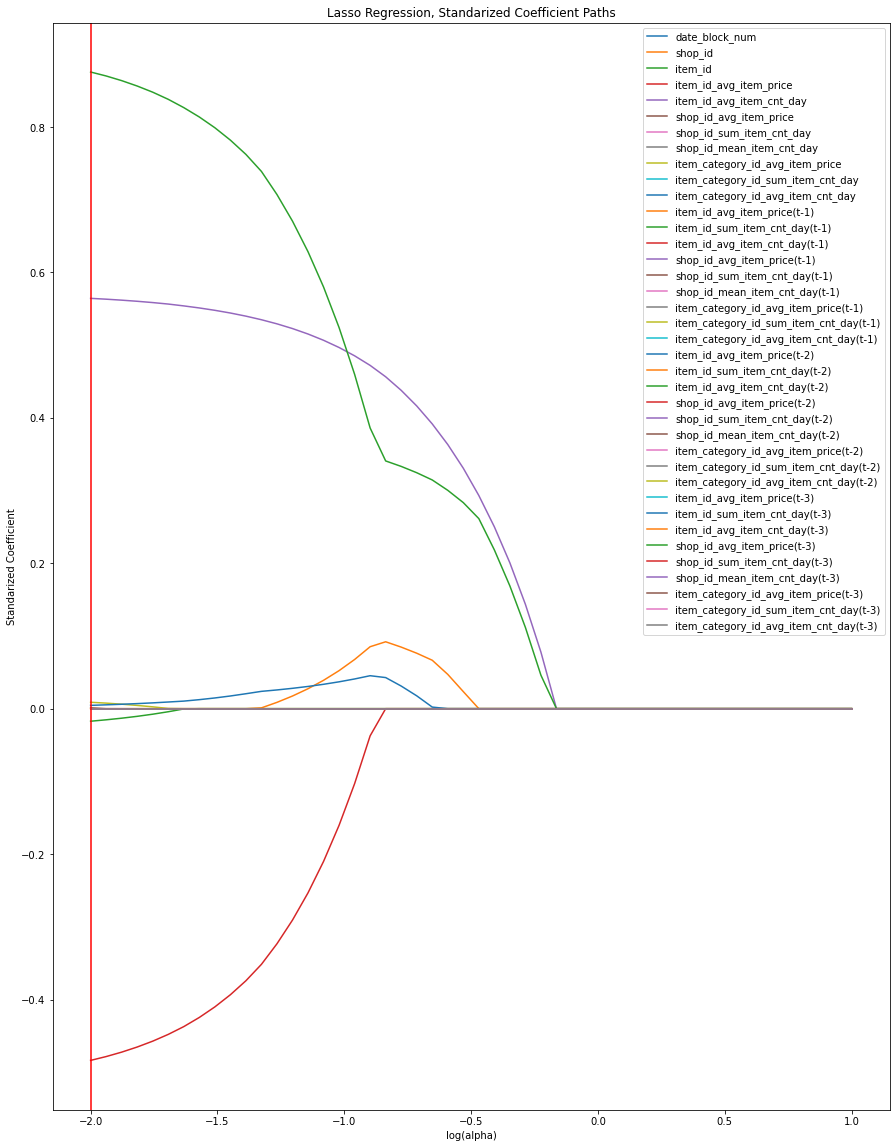

In [49]:
fig, ax = plt.subplots(figsize=(15,20))
for col in X_train.columns:
    path = df0.loc[:, col] # each col of df corresponds to each path (across diff alphas)
    ax.plot(np.log10(alphas), path, label=col)
ax.axvline(np.log10(optimal_alpha), color='red')
ax.legend()
ax.set_title('Lasso Regression, Standarized Coefficient Paths')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Standarized Coefficient');

In [66]:
X_arima = X_train['date_block_num'],y_train

In [67]:
X_arima.head()

AttributeError: 'tuple' object has no attribute 'head'

In [56]:
# fit an ARIMA model and plot residual errors


from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# fit model
model = ARIMA(X_train, order=(1,0,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

/Users/jiguzmans/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ValueError: SARIMAX models require univariate `endog`. Got shape (1286579, 38).

In [58]:
mod_ar2 = sm.tsa.SARIMAX(X_train, order=(1,0,0))

/Users/jiguzmans/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ValueError: SARIMAX models require univariate `endog`. Got shape (1286579, 38).